In [53]:
import json
import tqdm
import time
from operator import itemgetter
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import tensorflow as tf
import seaborn as sns
import numpy as np
import re
import joblib
import pandas as pd
from collections import defaultdict
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS

In [2]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense, Conv1D, Dropout, Embedding, concatenate, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import text, image, sequence
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow_addons.metrics import F1Score

In [69]:
print('Using tf version: {}'.format(tf.__version__))
print('Using numpy version: {}'.format(np.__version__))

Using tf version: 2.5.0
Using numpy version: 1.19.2


In [3]:
# folder of data
DATA_FOLDER = '../content'
# folder of data
EVALUATION_FOLDER = '../content/evaluation'
# path image format
IMAGE_FORMAT = '../content/%s/COCO_%s_%012d.jpg'

# batch size
BATCH_SIZE = 300

In [4]:
"""
    Input Questions Format
    
    question{
    "question_id" : int,
    "image_id" : int,
    "question" : str
}

"""
tTestQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_test2015_questions.json', 'r'))

In [5]:
# Display the first 5 test questions
tTestQuestions['questions'][:5]

[{'image_id': 262144,
  'question': 'Is the ball flying towards the batter?',
  'question_id': 262144000},
 {'image_id': 262144,
  'question': 'What sport is this?',
  'question_id': 262144001},
 {'image_id': 262144,
  'question': 'Can you see the ball?',
  'question_id': 262144002},
 {'image_id': 262144,
  'question': 'Is the pitcher wearing a hat?',
  'question_id': 262144003},
 {'image_id': 262144,
  'question': 'Will he catch the ball in time?',
  'question_id': 262144004}]

In [6]:
"""
    Function name: ProcessImageQuestion
    
    Objective: Creates a JSON file whose elements are (img_path, question, question_id)
    
    Summary algorithmic description: Loop over all questions to read all elements
                                     Add every element to the list
                                     Save the list to a JSON file
    
    Input parameters: sDataFolder: "test-dev2015" or "test2015"
    
    Return : None
    
    Date : 29/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ProcessImageQuestion(sDataFolder):
    # Read input question data
    tQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_{sDataFolder}_questions.json', 'r'))
    # list of dictionaries whose keys are (img_path, question, ans, answers)
    clData = []

    # Loop over all questions
    for iC in tqdm.tqdm(range(len(tQuestions['questions']))):
        # path image
        sImagePath = IMAGE_FORMAT%('test2015', 'test2015', tQuestions['questions'][iC]['image_id'])
        # question
        sQuestion = tQuestions['questions'][iC]['question']
        # question
        iQuestionId = tQuestions['questions'][iC]['question_id']
        # Add a element to the dictionary
        clData.append({'img_path': sImagePath, 'question': sQuestion, 'question_id': iQuestionId})
    
    # save to disk
    json.dump(clData, open(f'{EVALUATION_FOLDER}/vqa_raw_{sDataFolder}.json', 'w'))

In [7]:
# # Creates a JSON file whose elements are (img_path, question, question_id) for test data
# ProcessImageQuestion("test2015")

In [8]:
# Read test data
tTestData = json.load(open(f'{EVALUATION_FOLDER}/vqa_raw_test2015.json', 'r'))

In [9]:
# Display the first 5 data points
tTestData[:5]

[{'img_path': '../content/test2015/COCO_test2015_000000262144.jpg',
  'question': 'Is the ball flying towards the batter?',
  'question_id': 262144000},
 {'img_path': '../content/test2015/COCO_test2015_000000262144.jpg',
  'question': 'What sport is this?',
  'question_id': 262144001},
 {'img_path': '../content/test2015/COCO_test2015_000000262144.jpg',
  'question': 'Can you see the ball?',
  'question_id': 262144002},
 {'img_path': '../content/test2015/COCO_test2015_000000262144.jpg',
  'question': 'Is the pitcher wearing a hat?',
  'question_id': 262144003},
 {'img_path': '../content/test2015/COCO_test2015_000000262144.jpg',
  'question': 'Will he catch the ball in time?',
  'question_id': 262144004}]

In [10]:
# list of questions in test dataset
clQuestionTest = list(map(itemgetter('question'), tTestData))
# list of question ids in test dataset
clQuestionIdTest = list(map(itemgetter('question_id'), tTestData))
# list of image path in test dataset
clImagePathTest = list(map(itemgetter('img_path'), tTestData))

In [11]:
# load from disk: Encode target answers with value between 0 and n_classes-1
with open(f'{DATA_FOLDER}/AnswerEncoderTrainVal.pkl', 'rb') as f:
    oAnswerEncoder = joblib.load(f)

In [12]:
# load question tokenizer from disk
with open(f'{DATA_FOLDER}/question_tokenizer.pkl', 'rb') as f:
    oQuestionTok = joblib.load(f)

# Image features

## VGG

In [13]:
"""
    Function name: ImageFeatureExtractor
    
    Objective: Extract (49, 512)-dimensional CNN features by fine-tuning VGG19 and save them locally 
    
    Summary algorithmic description: Load pre-trained model VGG19, don't add final layer
                                     Pass the pprecessed images through the network and use the outputs as our actual features
                                     Save image features to image id folder
    
    Input parameters: sPathFeature: path to save the features
                      clImageFilename : list of image filenames
                      iBatchSize : batch size
    
    Return : None
    
    Date : 29/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ImageFeatureExtractor(sPathFeature, clImageFilename, iBatchSize):
    # Load pre-trained model graph, don't add final layer
    model = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

    # add a progress bar
    progbar = utils.Progbar(int(np.ceil(len(clImageFilename) / float(iBatchSize))))

    # loop over the images in batches
    for (iCounter, iBSize) in enumerate(range(0, len(clImageFilename), iBatchSize)):
        # extract batch of images and prepare them to pass it through the VGG 
        # network for feature extraction

        # Update the progress bar.
        progbar.update(iCounter+1)

        # range of batch
        itBatchRange = range(iBSize, min(iBSize + iBatchSize, len(clImageFilename)))
        # batch of image filenames
        clBatchImageFilename = clImageFilename[itBatchRange[0]: itBatchRange[-1]+1]

        # list of processed images
        clBatchImage = []
        # list of image ids 
        clBatchId = []
        # loop over the images in the current batch
        for sImageFilename in clBatchImageFilename:

            # load the input image, while ensuring the image is resized to 224x224 pixels
            img = image.load_img(f'{DATA_FOLDER}/test2015/' + sImageFilename, target_size=(224, 224))
            # Convert a PIL Image instance to a Numpy array.
            caImg = image.img_to_array(img)

            # expand the dimensions to include batch dim
            caImg = np.expand_dims(caImg, axis=0)
            # The image are converted from RGB to BGR, then each color channel is zero-centered 
            # with respect to the ImageNet dataset, without scaling.
            caImg = preprocess_input(caImg)

            # add the image to the batch
            clBatchImage.append(caImg)
            # Add the image id of the batch to the list of ids
            clBatchId.append(sImageFilename.split('.')[0][-6:])

        # Stack image arrays in sequence vertically (BATCH_SIZE, 224, 224, 3)
        clBatchImage = np.vstack(clBatchImage) 

        # Pass the images through the network and use the outputs as our actual features (BATCH_SIZE, 7, 7, 512)
        tsFeatures = model.predict(clBatchImage) 
        # Reshapes the features (BATCH_SIZE, 49, 512)
        tsFeatures = tf.reshape(tsFeatures, (tsFeatures.shape[0], -1, tsFeatures.shape[-1])) 

        # Loop over the batch to save them locally
        for sId, tsFeature in zip(clBatchId, tsFeatures):
            # Save image features to image id folder 
            np.save(os.path.join(sPathFeature, sId), tsFeature)

In [14]:
# clImageFilenameTest = os.listdir(f'{DATA_FOLDER}/test2015')

In [15]:
# ImageFeatureExtractor(f'{EVALUATION_FOLDER}/features', clImageFilenameTest, BATCH_SIZE)

## ResNet

In [16]:
"""
    Function name: ImageFeatureExtractor
    
    Objective: Extract (49, 2048)-dimensional CNN features by fine-tuning ResNet and save them locally 
    
    Summary algorithmic description: Load pre-trained model ResNet50, don't add final layer
                                     Pass the pprecessed images through the network and use the outputs as our actual features
                                     Save image features to image id folder
    
    Input parameters: sImageFolder : image folder name
                      sPathFeature: path to save the features
                      clImageFilename : list of image filenames
                      iBatchSize : batch size
    
    Return : None
    
    Date : 13/01/2022
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ImageFeatureExtractorResNet(sPathFeature, clImageFilename, iBatchSize):
    # Load pre-trained model graph, don't add final layer
    model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

    # add a progress bar
    progbar = utils.Progbar(int(np.ceil(len(clImageFilename) / float(iBatchSize))))

    # loop over the images in batches
    for (iCounter, iBSize) in enumerate(range(0, len(clImageFilename), iBatchSize)):
        # extract batch of images and prepare them to pass it through the VGG 
        # network for feature extraction

        # Update the progress bar.
        progbar.update(iCounter+1)

        # range of batch
        itBatchRange = range(iBSize, min(iBSize + iBatchSize, len(clImageFilename)))
        # batch of image filenames
        clBatchImageFilename = clImageFilename[itBatchRange[0]: itBatchRange[-1]+1]

        # list of processed images
        clBatchImage = []
        # list of image ids 
        clBatchId = []
        # loop over the images in the current batch
        for sImageFilename in clBatchImageFilename:

            # load the input image, while ensuring the image is resized to 224x224 pixels
            img = image.load_img(f'{DATA_FOLDER}/test2015/' + sImageFilename, target_size=(224, 224))
            # Convert a PIL Image instance to a Numpy array.
            caImg = image.img_to_array(img)

            # expand the dimensions to include batch dim
            caImg = np.expand_dims(caImg, axis=0)
            # The image are converted from RGB to BGR, then each color channel is zero-centered 
            # with respect to the ImageNet dataset, without scaling.
            caImg = preprocess_input(caImg)

            # add the image to the batch
            clBatchImage.append(caImg)
            # Add the image id of the batch to the list of ids
            clBatchId.append(sImageFilename.split('.')[0][-6:])

        # Stack image arrays in sequence vertically (BATCH_SIZE, 224, 224, 3)
        clBatchImage = np.vstack(clBatchImage) 

        # Pass the images through the network and use the outputs as our actual features (BATCH_SIZE, 7, 7, 2048)
        tsFeatures = model.predict(clBatchImage) 
        # Reshapes the features (BATCH_SIZE, 49, 2048)
        tsFeatures = tf.reshape(tsFeatures, (tsFeatures.shape[0], -1, tsFeatures.shape[-1])) 

        # Loop over the batch to save them locally
        for sId, tsFeature in zip(clBatchId, tsFeatures):
            # Save image features to image id folder 
            np.save(os.path.join(sPathFeature, sId), tsFeature)

In [17]:
# clImageFilenameTest = os.listdir(f'{DATA_FOLDER}/test2015')

In [18]:
# ImageFeatureExtractorResNet(f'{EVALUATION_FOLDER}/featuresResNet50', clImageFilenameTest, BATCH_SIZE)

# Text features

In [19]:
# load test question tokenizations from disk
with open(f'{DATA_FOLDER}/tokenised_question_paddingPost_test.pkl', mode='rb') as f:
    caQuestionTestTokenized = joblib.load(f)

# Model

In [20]:
"""
    Class name: AttentionMaps 
    
    Objective: Compute the image (or question) attention
    
    Summary algorithmic description: Calculate the affinity matrix
                                     Predict image and question attention maps
    
    Input parameters: iDim_k : hidden attention dimention
                      fRegValue : Regularization value
    
    Date : 14/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
class AttentionMaps(tf.keras.layers.Layer):
    """
        Function name: __init__

        Objective: Define custom layer attributes

        Summary algorithmic description: Define two attributes hidden attention dimention and regularization value
                                         Define the weight parameters by layer Dense

        Input parameters: iDim_k : hidden attention dimention
                          fRegValue : Regularization value

        Return : None

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def __init__(self, iDim_k, fRegValue, **kwargs):
        # Default layer attributes
        super(AttentionMaps, self).__init__(**kwargs)

        # Get the value of hidden attention dimention
        self.iDim_k = iDim_k
        # Get the regularization value 
        self.fRegValue = fRegValue

        # Dense layer with Xavier uniform initializer for image weight parameters 
        self.Wv = Dense(self.iDim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=2))
        # Dense layer with Xavier uniform initializer for question weight parameters
        self.Wq = Dense(self.iDim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))
        
        
    """
        Function name: call

        Objective: Perform the logic of applying the layer to the input tensors

        Summary algorithmic description: Calculate the affinity matrix
                                         Predict image and question attention maps

        Input parameters: caImageFeat : image feature (b, N,  d) 
                          caQuestionFeat : question feature (b, T,  d)

        Return : image attention map and question attention map

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def call(self, caImageFeat, caQuestionFeat):
        # Affinity Matrix C = tanh((QT)(Wb)V) (b, T, N)
        C = tf.matmul(caQuestionFeat, tf.transpose(caImageFeat, perm=[0,2,1])) 
        C = tf.keras.activations.tanh(C) 

        # (Wv)V (b, N, k)
        Wv_V = self.Wv(caImageFeat)                             
        # (Wq)Q (b, T, k)
        Wq_Q = self.Wq(caQuestionFeat)                              

        # ((Wq)Q)C (b, k, N)
        Wq_Q_C = tf.matmul(tf.transpose(Wq_Q, perm=[0,2,1]), C) 
        # ((Wq)Q)C (b, N, k)
        Wq_Q_C = tf.transpose(Wq_Q_C, perm =[0,2,1])       

        # ((Wv)V)CT (b, k, T)                                         
        Wv_V_CT = tf.matmul(tf.transpose(Wv_V, perm=[0,2,1]), tf.transpose(C, perm=[0,2,1])) 
        # ((Wv)V)CT (b, T, k) 
        Wv_V_CT = tf.transpose(Wv_V_CT, perm =[0,2,1])         

        # image attention map Hv = tanh((Wv)V + ((Wq)Q)C) (b, N, k)
        Hv = Wv_V + Wq_Q_C                                     
        Hv = tf.keras.activations.tanh(Hv)              

        # question attention map Hq = tanh((Wq)Q + ((Wv)V)CT) (b, T, k)
        Hq = Wq_Q + Wv_V_CT                                     
        Hq = tf.keras.activations.tanh(Hq)                   

        # Return image attention map and question attention map
        return [Hv, Hq]                                     
  

    """
        Function name: get_config

        Objective: Collect the input shape and other information about the layer.

        Summary algorithmic description: Return a dictionary containing the configuration used to initialize this layer

        Input parameters: None

        Return : a dictionary containing informations about the layer.

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def get_config(self):
        # Dictionnary of two attributes of this layer
        cdConfig = {
            'iDim_k': self.iDim_k,
            'fRegValue': self.fRegValue
        }
        # Dictionnary of base configurations
        cdBasaConfig = super(AttentionMaps, self).get_config()
        # Return a dictionary containing informations about the layer.
        return dict(list(cdBasaConfig.items()) + list(cdConfig.items()))

In [21]:
"""
    Class name: ContextVector 
    
    Objective: Find context vector of the image and text features
    
    Summary algorithmic description: 
    
    Input parameters: iDim_k : hidden attention dimention
                      fRegValue : Regularization value
    
    Date : 14/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
class ContextVector(tf.keras.layers.Layer):
    """
        Function name: __init__

        Objective: Define custom layer attributes

        Summary algorithmic description: Define attribute regularization value
                                         Define the weight parameters by layer Dense

        Input parameters: fRegValue : Regularization value

        Return : None

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def __init__(self, fRegValue, **kwargs):
        # Default layer attributes
        super(ContextVector, self).__init__(**kwargs)

        # Get the regularization value 
        self.fRegValue = fRegValue
        # Image weight parameters (Dense layer with Xavier uniform initializer)
        self.whv = Dense(1, activation='softmax',\
                            kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=4))
        # Image weight parameters (Dense layer with Xavier uniform initializer)
        self.whq = Dense(1, activation='softmax',\
                            kernel_regularizer=tf.keras.regularizers.l2(self.fRegValue),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5)) 
    

    """
        Function name: call

        Objective: Perform the logic of applying the layer to the input tensors

        Summary algorithmic description: Find context vector of the image and text features

        Input parameters: caImageFeat : image feature (b, N,  d) 
                          caQuestionFeat : question feature (b, T,  d)
                          Hv : image attention map (b, N, k)
                          Hq : question attention map (b, T, k)

        Return : context vector of the image and text features

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def call(self, caImageFeat, caQuestionFeat, Hv, Hq):
        # attention probabilities of each image region vn
        # av = softmax(wT_hv * H_v) (b, N, 1)
        av = self.whv(Hv)                               

        # attention probabilities of each word qt      
        # aq = softmax(wT_hq * H_q) (b, T, 1)
        aq = self.whq(Hq)                              

        # context vector for image (b, N, d)
        v = av * caImageFeat 
        # context vector for image (b, d)
        v = tf.reduce_sum(v, 1)                            

        # context vector for question (b, T, d)
        q = aq * caQuestionFeat                               
        # context vector for question (b, d)
        q = tf.reduce_sum(q, 1)            
        
        # Return context vector of the image and text features
        return [v, q]

    
    """
        Function name: get_config

        Objective: Collect the input shape and other information about the layer.

        Summary algorithmic description: Return a dictionary containing the configuration used to initialize this layer

        Input parameters: None

        Return : a dictionary containing informations about the layer.

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def get_config(self):
        # Dictionnary of attributes of this layer
        cdConfig = {
            'fRegValue': self.fRegValue
        }
        # Dictionnary of base configurations
        cdBaseConfig = super(ContextVector, self).get_config()
        # Return a dictionary containing informations about the layer
        return dict(list(cdBaseConfig.items()) + list(cdConfig.items()))

In [22]:
"""
    Class name: PhraseLevelFeatures 
    
    Objective: Compute the phrase features by applying 1-D convolution on the word embedding vectors
    
    Summary algorithmic description: Applying 1-D convolution with filters of three window sizes: unigram, bigram and trigram
                                     Max-pooling across different n-grams at each word location
    
    Input parameters: iDim_d : hidden dimension
    
    Date : 14/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
class PhraseLevelFeatures(tf.keras.layers.Layer):
    """
        Function name: __init__

        Objective: Define custom layer attributes

        Summary algorithmic description: Define attribute hidden dimension
                                         Define the weight parameters by 1D convolution layer

        Input parameters: iDim_d : hidden dimension

        Return : None

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def __init__(self, iDim_d, **kwargs):
        # Default layer attributes
        super(PhraseLevelFeatures, self).__init__(**kwargs)

        # Get the hidden dimension
        self.iDim_d = iDim_d
        # Convolution with filter unigram
        self.conv_unigram = Conv1D(self.iDim_d, kernel_size=1, strides=1,\
                                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=6)) 
        # Convolution with filter bigram
        self.conv_bigram =  Conv1D(self.iDim_d, kernel_size=2, strides=1, padding='same',\
                                    kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7)) 
        # Convolution with filter trigram
        self.conv_trigram = Conv1D(self.iDim_d, kernel_size=3, strides=1, padding='same',\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=8)) 

        
    """
        Function name: call

        Objective: Perform the logic of applying the layer to the input tensors

        Summary algorithmic description: Compute the n-gram phrase embeddings (n = 1,2,3)

        Input parameters: caWordFeat : word feature (b, T, d) 

        Return : Phrase level features of the question (b, T, d)

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def call(self, caWordFeat):
        # phrase level unigram features (b, T, d)
        qpUnigram = self.conv_unigram(caWordFeat)                    

        # phrase level bigram features (b, T, d)
        qpBigram  = self.conv_bigram(caWordFeat)                     

        # phrase level trigram features (b, T, d)
        qpTrigram = self.conv_trigram(caWordFeat)             

        # phrase level features (b, T, d, 3)
        qp = tf.concat([tf.expand_dims(qpUnigram, -1),\
                        tf.expand_dims(qpBigram, -1),\
                        tf.expand_dims(qpTrigram, -1)], -1)         

        # Max-pool across n-gram features, over-all phrase level feature (b, T, d)
        qp = tf.reduce_max(qp, -1)                                

        # Return phrase level features
        return qp

    """
        Function name: get_config

        Objective: Collect the input shape and other information about the layer.

        Summary algorithmic description: Return a dictionary containing the configuration used to initialize this layer

        Input parameters: None

        Return : a dictionary containing informations about the layer.

        Date : 14/11/2021

        Coding: INSA CVL - Van Tuan BUI  
    """
    def get_config(self):
        # Dictionnary of attributes of this layer
        cdConfig = {
            'iDim_d': self.iDim_d
        }
        # Dictionnary of base configurations
        cdBaseConfig = super(PhraseLevelFeatures, self).get_config()
        # Return a dictionary containing informations about the layer
        return dict(list(cdBaseConfig.items()) + list(cdConfig.items()))

# Architecture

In [23]:
# trained model file
MODEL_FILE = 'TrainVal_CoAttention_Resnet50_model.h5'

In [24]:
# Load trained model
oModel = tf.keras.models.load_model(f'{DATA_FOLDER}/{MODEL_FILE}', 
                                    custom_objects={"PhraseLevelFeatures": PhraseLevelFeatures,
                                                    "AttentionMaps": AttentionMaps,
                                                    "ContextVector": ContextVector
                                                   }
)

In [25]:
oModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        [(None, 49, 2048)]   0                                            
__________________________________________________________________________________________________
Image_Feat_Dense (Dense)        (None, 49, 512)      1049088     Image_Input[0][0]                
__________________________________________________________________________________________________
Question_Input (InputLayer)     [(None, 22)]         0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 49, 512)      0           Image_Feat_Dense[0][0]           
______________________________________________________________________________________________

In [26]:
# batch size
BATCH_SIZE = 300

In [27]:
"""
    Function name: GetImageFeaturesToEvalue

    Objective: Load the image features from numpy files for evaluation

    Summary algorithmic description: Load the image features from numpy files

    Input parameters: sPathImage : path image
                      caQuestion : Tokenization of question

    Return : caImageTensor : image features
             caQuestion : Tokenization of question 

    Date : 26/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def GetImageFeaturesToEvalue(sPathImage, caQuestion):
    # Load the image features from numpy file
    caImageTensor = np.load(f'{EVALUATION_FOLDER}/featuresResNet50/' + sPathImage.decode('utf-8').split('.')[2][-6:] + '.npy')
    # Return image features, tokenization of question
    return caImageTensor, caQuestion

In [28]:
# Create a Dataset test evaluation whose elements are slices along their first dimension
oDatasetTestEvaluation = tf.data.Dataset.from_tensor_slices((clImagePathTest, caQuestionTestTokenized))

# Use map to load the numpy files in parallel
oDatasetTestEvaluation = oDatasetTestEvaluation.map(lambda sPathImage, sQuestion: tf.numpy_function(
    GetImageFeaturesToEvalue, [sPathImage, sQuestion], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batch
oDatasetTestEvaluation = oDatasetTestEvaluation.batch(BATCH_SIZE)

In [29]:
"""
    Function name: PredictAnswers

    Objective: Predict answers based on our trained model

    Summary algorithmic description: trained model result probabilities of the final answer
                                     Transform labels back to answers

    Input parameters: oDataset : dataset to predict
                      oModel : trained model
                      oLabelEncoder : Encoder of target answers

    Return : tsAnswer : answers

    Date : 26/11/2021

    Coding: INSA CVL - Van Tuan BUI  
"""
def PredictAnswers(oDataset, oModel, oLabelEncoder):
    # all predictions of dataset
    clPrediction = []
    # Loop over all elements in the dataset
    for sPathImage, caQuestionToken in (oDataset):
        # probabilities of the final answer
        tsPrediction = oModel([sPathImage, caQuestionToken])
        # Add the prediction to the end of the list
        clPrediction.extend(tsPrediction)

    # indexes of the largest activation
    tsClasse = tf.argmax(clPrediction, axis=1, output_type=tf.int32)
    # Back to Answer
    caAnswer = (oLabelEncoder.inverse_transform(tsClasse))
    return caAnswer

In [30]:
# predict answers for the test set
caTestPredictedAnswer = PredictAnswers(oDatasetTestEvaluation, oModel, oAnswerEncoder)

In [31]:
# save to disk
with open(f'{EVALUATION_FOLDER}/predicted_answers_test.pkl', 'wb') as f:
    joblib.dump(caTestPredictedAnswer, f)

In [32]:
# load from disk
with open(f'{EVALUATION_FOLDER}/predicted_answers_test.pkl', 'rb') as f:
    caTestPredictedAnswer = joblib.load(f)

In [56]:
"""
    Function name: DisplayRandomVQATest
    
    Objective: Display Visual Question Answering for test set
    
    Summary algorithmic description: Read an image from a file into an array
                                     Display image with a title of question and answer
    
    Input parameters: None
    
    Return : None
    
    Date : 03/12/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def DisplayRandomVQATest():
    # Create a figure with 3 subplots
    oFig, (oAx1, oAx2, oAx3) = plt.subplots(1, 3, figsize=(15,10))
    
    # random index of image
    iIndex = random.randint(0, len(clImagePathTest) - 1)
    # Read an image from a file into an array
    caImage = plt.imread(clImagePathTest[iIndex])
    # Set a title for the subplot : question and it's answer
    oAx1.set_title(f'Q: {clQuestionTest[iIndex]} \n A: {caTestPredictedAnswer[iIndex]}')
    # Display image
    oAx1.imshow(caImage)
    
    # random index of image
    iIndex = random.randint(0, len(clImagePathTest) - 1)
    # Read an image from a file into an array
    caImage = plt.imread(clImagePathTest[iIndex])
    # Set a title for the subplot : question and it's answer
    oAx2.set_title(f'Q: {clQuestionTest[iIndex]} \n A: {caTestPredictedAnswer[iIndex]}')
    # Display image
    oAx2.imshow(caImage)
    
    # random index of image
    iIndex = random.randint(0, len(clImagePathTest) - 1)
    # Read an image from a file into an array
    caImage = plt.imread(clImagePathTest[iIndex])
    # Set a title for the subplot : question and it's answer
    oAx3.set_title(f'Q: {clQuestionTest[iIndex]} \n A: {caTestPredictedAnswer[iIndex]}')
    # Display image
    oAx3.imshow(caImage)

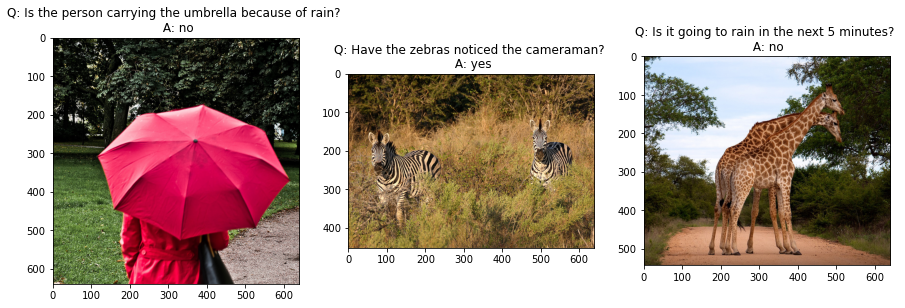

In [67]:
# Display Visual Question Answering for test set
DisplayRandomVQATest()

In [35]:
# list of predicted answers
clResult = []
# Loop over all question ids
for iIndex in range(len(clQuestionIdTest)):
    # dictionary answer
    cdAnswer = {}
    # predicted answer
    cdAnswer['answer'] = caTestPredictedAnswer[iIndex]
    # question id
    cdAnswer['question_id'] = clQuestionIdTest[iIndex]
    # Add dictionary answer to the list
    clResult.append(cdAnswer)

In [36]:
# Write predicted answers to a file json
with open(f'{EVALUATION_FOLDER}/test_answers_result.json', 'w') as f:
    json.dump(clResult, f)

# Result

<table>
  <tr>
    <th> Model </th>
    <th> Yes/No </th>
    <th> Number </th>
	<th> Other  </th>
	<th> All </th>
  </tr>
  <tr>
    <td> VGG </td>
    <td> 66.61 </td>
    <td> 31.39 </td>
	<td> 33.74 </td>
	<td> 47.02 </td>
  </tr>
  <tr>
    <td> ResNet </td>
    <td> 69.08 </td>
    <td> 34.58 </td>
	<td> 38.45 </td>
	<td> 50.73 </td>
  </tr>
</table>